# Мультиклассовый SVM-классификатор (Support Vector Machine)


*Заполните этот блокнот, выполните код и защитите результаты. Полностью заполненный блокнот необходимо сохранить в электронном виде, передав его копию преподавателю, ведущему занятия. 

В этом упражнении вы должны будете:
    
- реализовать полностью векторизованную **функцию потерь** для SVM
- реализовать полностью векторизованное выражение для её **аналитического градиента**
- **проверить свою реализацию** с помощью численного градиента
- использовать валидационное множество для подбора **скорости обучения и коэффициента регуляризации**
- **оптимизировать** функцию потерь с помощью алгоритма **SGD**
- **визуализировать** окончательные обученные веса классификатора

Этот блокнот является адаптированной версией аналогичного курса [Стэнфордского университета](http://vision.stanford.edu/teaching/cs231n/index.html)


In [1]:
# Выполните некоторые установки для этого блокнота.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# Это некоторая магия, чтобы изображения matplotlib отображались в блокноте,
# а не в новом окне.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Еще немного магии, чтобы блокнот перезагружал внешние модули python;
# см. http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Загрузка базы данных CIFAR-10 и предобработка

In [18]:
# Загрузка базы CIFAR-10.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Очистка переменных для предотвращения повторной загрузки данных (что может вызвать проблемы с памятью)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Для проверки работоспособности, распечатаем размер данных обучения и тестирования.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


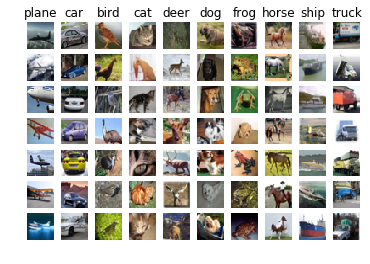

In [19]:
# Визуализируем некоторые изображения из набора данных.
# Показыважем несколько примеров изображений из каждого класса.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [20]:
# Разделение данных на обучающие (train), валидационные(val) и тестовые (test). 
# Создание небольшого множества данных для проведения экспериментов;
# Мы будем использовать это множество в процессе разработки, чтобы сократить время вычислений.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Валидационное множество содержит  num_validation элементов исходного обучающего множества.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Обучающее множество содержит num_train элементов исходного обучающего множества.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# Создание небольшого множества для разработки (_dev), которое является частью обучающего множества
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]


# Использование первых num_test элементов исходного тестового множества в качестве тестового подмножества
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [21]:
# Предобработка: реформатирование изображений в векторы
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# Для проверки распечатаем размерности данных
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


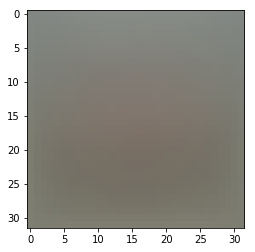

In [22]:
# Предобработка: вычитание среднего изображения
# 1: вычисляем среднее по обучающему множеству
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # вывод нескольких эл-тов
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) #визуализация среднего изображения
plt.show()

In [23]:
# 2: вычитаем среднее изображение из обучающего и других множеств
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [24]:
# 3: добавляем еще одно измерение для смещения (трюк со смещением), чтобы
# при оптимизации мы занимались только оптимизацией одной матрицы весов W

X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM классификатор

Ваш код для этой части задания должен быть написан в файле **cs231n/classifiers/linear_svm.py**. 

Как вы можете видеть, мы частично написали функцию `compute_loss_naive`, которая использует циклы for для оценки многоклассовой SVM функции потерь

In [28]:
# Оцените наивную реализацию функции потерь, которой мы снабдили Вас
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# генерация случайной матрицы весов с малыми значениями
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.424233


Градиент `grad`, возвращаемый функцией, вызываемой выше, в данный момент равен нулю.
Выведите формулы и реализуйте вычисление градиента для SVM функции потерь, реализуйте вычисления внутри функции `svm_loss_naive`. 

Чтобы убедиться, что вы правильно определили аналитический градиент, сравните его с численной оценкой градиента. Мы предоставили код, который сделает это за вас:


In [29]:
# После того как вы реализовали вычисление аналитического градиента, вычислите его с помощью кода ниже
# и выполните проверку градиента с помощью функции, которую мы вам предоставили

# Вычисляем функцию потерь и ее градиент по W.

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Вычислияем градиент вдоль нескольких случайно выбранных измерений и
# сравниваем с аналитически вычисляемым градиентом. Числа должны совпадать
# почти точно по всем измерениям.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# Повторите проверку градиента с включенной регуляризацией
# Вы не забыли градиент регуляризационной составляющей функции потерь, не так ли?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -39.663793 analytic: -39.663793, relative error: 4.562821e-12
numerical: -34.275749 analytic: -34.275749, relative error: 3.781705e-12
numerical: -64.268712 analytic: -64.268712, relative error: 4.876939e-12
numerical: -2.979179 analytic: -2.979179, relative error: 1.141016e-10
numerical: -1.233940 analytic: -1.233940, relative error: 2.160739e-10
numerical: -30.708987 analytic: -30.708987, relative error: 7.004954e-12
numerical: 1.310396 analytic: 1.310396, relative error: 2.979293e-10
numerical: 5.314181 analytic: 5.314181, relative error: 8.533091e-12
numerical: -17.590807 analytic: -17.590807, relative error: 8.677191e-12
numerical: -1.823427 analytic: -1.823427, relative error: 1.313001e-10
numerical: -1.266157 analytic: -1.271479, relative error: 2.097026e-03
numerical: -4.417609 analytic: -4.419565, relative error: 2.213343e-04
numerical: 6.053623 analytic: 6.057580, relative error: 3.267739e-04
numerical: -10.998340 analytic: -10.990277, relative error: 3.666928e-04


### Вопрос 1:
Возможно,что по некоторым измерениям результаты проверки градиента не будут точно совпадать. Как могло возникнуть такое расхождение? Нужно ли беспокоиться? Какой простой пример в одномерном случае, для которого  проверка градиента может завершиться неудачей? Как влияет значение отступа (margin) на частоту этого события? * Подсказка: SVM функция потерь не является строго говоря дифференцируемой *



**Ваш ответ:** Да, когда числовой градиент не вычислим. Например - когда x = 0, аналитический и численный градиент не будут совпадать.

In [31]:
# Реализуйте функцию svm_loss_vectorized; пока только вычислите потери;
# вычисление градиента реализуем ниже.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))


# Потери должны совпадать, но ваша векторная реализация должна быть намного быстрее.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.424233e+00 computed in 0.090002s
Vectorized loss: 9.424233e+00 computed in 0.009979s
difference: -0.000000


In [32]:
# Завершите реализацию svm_loss_vectorized и вычислите градиент
# функции потерь с помощью векторизованного кода.

# Результаты счета наивной и векторизованной реализаций должны совпадать, но
# векторизванная версия должна быть  быстрее.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# Потери - это одно число, поэтому легко сравнивать вычисленные значения
# двумя реализациями. Градиенты, с другой стороны, являются матрицами, поэтому
# мы используем норму Фробениуса для их сравнения.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.109994s
Vectorized loss and gradient: computed in 0.019986s
difference: 0.000000


### Стохастический градиентный спуск (SGD- Stochastic Gradient Descent)

Теперь у нас есть векторизованные и эффективные выражения для оценки потерь и градиента. Аналитический градиент соответствуют численному градиенту. Поэтому мы готовы применить SGD для минимизации потерь.

In [33]:
# В файле linear_classifier.py реализуйте алгоритм SGD в функции
# LinearClassifier.train(), а затем запустите его с помощью кода ниже.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 788.990513
iteration 100 / 1500: loss 471.035431
iteration 200 / 1500: loss 286.448008
iteration 300 / 1500: loss 173.410788
iteration 400 / 1500: loss 107.029261
iteration 500 / 1500: loss 66.285599
iteration 600 / 1500: loss 42.639721
iteration 700 / 1500: loss 27.201091
iteration 800 / 1500: loss 18.799654
iteration 900 / 1500: loss 13.263189
iteration 1000 / 1500: loss 11.026092
iteration 1100 / 1500: loss 8.540412
iteration 1200 / 1500: loss 7.201330
iteration 1300 / 1500: loss 6.212885
iteration 1400 / 1500: loss 5.627167
That took 20.061087s


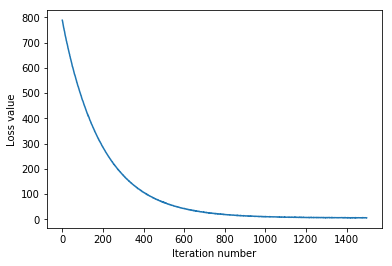

In [34]:
# Полезная стратегия отладки заключается в том, чтобы вычислять потери как функцию
# номер итерации:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [35]:
# Напишите функцию LinearSVM.predict и оцените эффективность как на
# тренировочном, так и на проверочном множествах
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.380878
validation accuracy: 0.388000


In [36]:
# Используйте валидационное мн-во для выбора гиперпараметров (коэффициента регуляризации и
# скорости обучения). Вы должны экспериментировать с различными значениями скорости обучения
# и коэффициента регуляризации; вы должны получить точность классификации около 0,4 валидационном мн-ве.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]


# results - является словарем, отображающим кортежи вида
# (learning_rate, regularization_strength) в кортежи вида
# (training_accuracy, validation_accuracy). Точность - это просто доля
# данных, которые правильно классифицированы.
results = {}
best_val = -1   # Наивысшая валидац. точность, которая наблюдалась до этого момента.
best_svm = None # Объект LinearSVM, для которого получена наивысшая валидац. точность.

################################################################################
# ЗАДАНИЕ:                                                                     #
# Напишите код, который выбирает лучшие гиперпараметры, используя              #
# валидационное мн-во. Для каждой комбинации гиперпараметров обучите           #
# линейный SVM на обучающем множестве, определите точность на обучающем и      #
# валидационном мн-вах, сохраните эти числа в словаре результатов. Кроме того, #
# сохраните лучшую валидац. точность в best_val, а объект LinearSVM., для      #
# которого достигнута эта точность, сохраните в best_svm.                      #
#                                                                              #
# Совет: вы должны использовать небольшое значение для num_iters при           #
# разработке своего валидационного кода, чтобы SVM не требовал много времени   #
# для обучения; как только вы будете уверены, что ваш код работает, вы должны  #
# повторно запустить валидационный код с большим значением для num_iters.      #
################################################################################
for rs in regularization_strengths:
    for lr in learning_rates:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate= lr, reg= rs, num_iters=1500, verbose=False)
        y_train_pred = svm.predict(X_train)
        training_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        validation_accuracy = np.mean(y_val == y_val_pred)
        results[(lr, rs)] = (training_accuracy, validation_accuracy)
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_svm = svm
################################################################################
#                              КОНЕЦ ВАШЕГО КОДА                               #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

C:\Users\СевГУ.DESKTOP-TRLVR9T\Desktop\DLandCV_ЛР_часть1_18_10_2018\cs231n\classifiers\linear_svm.py:84: RuntimeWarning: overflow encountered in double_scalars
  #                             КОНЕЦ ВАШЕГО КОДА                             #
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\СевГУ.DESKTOP-TRLVR9T\Desktop\DLandCV_ЛР_часть1_18_10_2018\cs231n\classifiers\linear_svm.py:84: RuntimeWarning: overflow encountered in multiply
  #                             КОНЕЦ ВАШЕГО КОДА                             #


lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.382367 val accuracy: 0.386000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.361755 val accuracy: 0.382000
lr 5.000000e-05 reg 2.500000e+04 train accuracy: 0.141816 val accuracy: 0.158000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.049980 val accuracy: 0.046000
best validation accuracy achieved during cross-validation: 0.386000


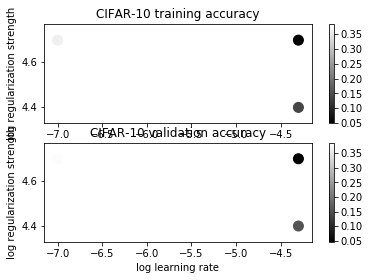

In [37]:
# Визуализация результатов кросс-валидации
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# отображение точности обучения
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# отображение точности валидации
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [38]:
# Оценивание лучшего SVM классификатора на тестовом мн-ве
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.381000


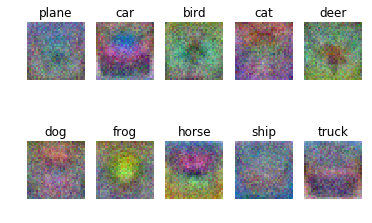

In [39]:
# Визуализация обученных весов для каждого класса.
# В зависимости от вашего выбора скорости обучения и силы регуляризации, это может
# выглядеть хорошо или плохо.


w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Вопрос  2:

Опишите ваши визуализированные веса SVM классификатора, и дайте краткое объяснение, почему они выглядят таким образом.

**Ваш ответ:** Веса имеют расплывчатое значение. Каждый из них может описать основную конструкцию большинства обучающих образов на одном изображении. При этом упор идет на цвета изображения. Например, лошадь показывает небольшой намек на то, что учебные образцы состоят из лошади и зеленой земли.